# Mid Term 1 - KNN & Logistic Regression
*Authors*:  
- Aliotta Lorenzo, S5655762
- Prataiolo Loris, S4632180



# Introduction

This notebook explores and compares two fundamental algorithms to solve classification problems: $K$-Nearest Neighbors ($K$NN) and Logistic Regression (LR). 
We will implement these algorithms from scratch, including cross-validation for hyperparameter tuning, and evaluate their performance on synthetic linearly separable datasets of varying dimensions and sizes. 
The analysis will focus on understanding their accuracy, execution time, and how their optimal hyperparameters change across different datasets.


### Libraries and utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator
import time
from scipy.spatial.distance import cdist

In [2]:
def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)

### Datasets loading

In [3]:
ds1 = np.load("synthetic_linear_gaussian/linsep_d2_n200.npz")     # (d = 2 ;  n = 200)
ds2 = np.load("synthetic_linear_gaussian/linsep_d10_n1000.npz")   # (d = 10;  n = 1000)
ds3 = np.load("synthetic_linear_gaussian/linsep_d500_n50000.npz") # (d = 500; n = 50000)

# KNN

## Methods

In [4]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [5]:
def allDistances(X1, X2):
    '''
    Compute pairwise Euclidean distnaces between two X sets.
    output: D :=  A matrix (X1_rows x X2_rows) where D[i, j] equals the Euclidean distance 
                  between the i-th sample in X1 and the j-th sample in X2.
    '''
    return cdist(X1, X2, metric='euclidean')

In [6]:
def kNNClassify(Xtr, Ytr, k, Xte, dist):

    n_train = Xtr.shape[0]  # number of the training inputs
    n_test  = Xte.shape[0]  # number of the test inputs

    # sanity checks
    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):

        # Take all distances for the current test point and sort them 
        curr_dist = dist[:,idx]
        ord_idx = np.argsort(curr_dist)
        # Get the indices of the k lowest of distances
        k_dist_idx = ord_idx[:k]
        # Compute the mean of the output values of the corresponding training points and taking the sign of it.
        ## Note: no need to compute the mean, the sum is sufficient
        Ypred[idx] = np.sign(sum(Ytr[k_dist_idx])) # returns -1 if x < 0, 0 if x==0, 1 if x > 0
        
    return Ypred

In [7]:
def KFoldCVkNN(Xtr, Ytr, num_folds, k_list, rng: int | Generator | None = None):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rng = _check_random_generator(rng)
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]

    # Compute the matrix of distances
    dist = allDistances(Xtr, Xtr)
    
    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds)) # train
    val_errors = np.zeros((num_k, num_folds)) # validation

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds) 
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        
        # Split training set in training part and validation part
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]

        x_val   = Xtr[val_mask==True]
        y_val   = Ytr[val_mask==True]

        # Get the batch of distances that we need for this part
        #print(f"Matrix of distances:\n{dist.shape}")
        dist_tr = ((dist[val_mask==False].T)[val_mask==False]).T
        #print(f"New matrix: {dist_tr.shape}")
        dist_val = ((dist[val_mask==False].T)[val_mask==True]).T
        #print(f"New matrix: {dist_val.shape}")
        
        for k_idx, current_k in enumerate(k_list):
            # Compute the training error of the kNN classifier for the given value of k
            Tpred = kNNClassify(x_train, y_train, current_k, x_train, dist_tr)
            tr_errors[k_idx, fold_idx] = calcError(Tpred, y_train)
            
            # Compute the validation error of the kNN classifier for the given value of k
            Vpred = kNNClassify(x_train, y_train, current_k, x_val, dist_val)
            val_errors[k_idx, fold_idx] = calcError(Vpred, y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)

    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.where(k_list == best_k)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [8]:
def plot_training_validation_error_mean(k_list, best_k, val_err_mean, val_err_std, tr_err_mean, tr_err_std, num_folds):
    
    fig, ax = plt.subplots()
    ax.plot(k_list, val_err_mean, label="Validation")
    ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.plot(k_list, tr_err_mean, label="Training")
    ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

    ax.axvline(x=best_k, color='g', lw=1, label=r"best $K$ = "+str(best_k))
    
    ax.set_ylim(bottom=max(min(min(val_err_mean - val_err_std), min(tr_err_mean - tr_err_std))-0.01, -0.01), top=min(max(max(val_err_mean + val_err_std), max(tr_err_mean + tr_err_std))+0.01, 1.01))
    ax.set_title(f"{num_folds}-Fold CV")
    ax.set_ylabel("Error")
    ax.set_xlabel(f"$K$ values")
    ax.legend(loc="upper right")

In [9]:
def perform_knn_process(dataset, k_values=np.arange(1,32,2), rng: int | Generator | None = None):

    Xtr = dataset['X_train']
    Xte = dataset['X_test']
    Ytr = dataset['y_train']
    Yte = dataset['y_test']

    num_folds = 5

    best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr, Ytr, num_folds=num_folds, k_list=k_values, rng=rng)

    plot_training_validation_error_mean(k_values, best_k, val_err_mean, val_err_std, tr_err_mean, tr_err_std, num_folds)
    
    # evaluate the error for training set and test set using the best k
    # and estimate the performing time of KNN Classifier

    
    tr_start = time.perf_counter() 
    dist_tr = allDistances(Xtr, Xtr)
    #print(dist_tr.shape)
    tr_pred = kNNClassify(Xtr, Ytr, best_k, Xtr, dist_tr)
    tr_end   = time.perf_counter()
    
    te_start = time.perf_counter()
    dist_te = allDistances(Xtr, Xte)
    #print(dist_te.shape)
    te_pred = kNNClassify(Xtr, Ytr, best_k, Xte, dist_te)
    te_end   = time.perf_counter()

    tr_error = calcError(tr_pred, Ytr)
    te_error = calcError(te_pred, Yte)

    print(f"Best K: {best_k}\n")
    print("=== TRAINING STAT ===")
    print(f"Error: {tr_error*100:.3f}%")
    print(f"Execution Time: {tr_end-tr_start:.8f} seconds\n")
    
    print("=== TEST STAT ===")
    print(f"Error: {te_error*100:.3f}%")
    print(f"Execution Time: {te_end-te_start:.8f} seconds")

## Test on datasets

###  Analysis on first dataset (d = 2 ;  n = 200)

Best K: 7

=== TRAINING STAT ===
Accuracy (error): 9.333%
Execution Time: 0.00080204 seconds

=== TEST STAT ===
Accuracy (error): 12.000%
Execution Time: 0.00026542 seconds


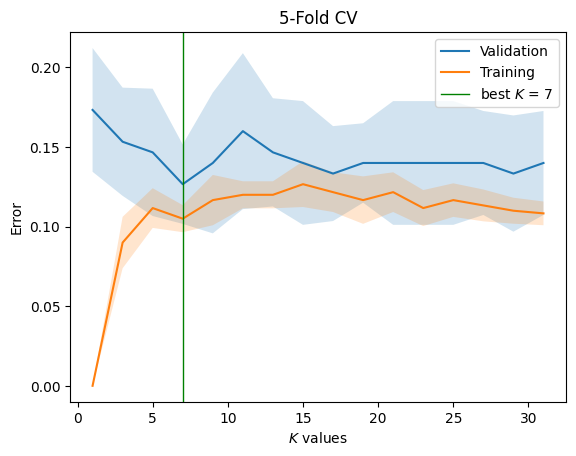

In [10]:
random_seed = 2306
perform_knn_process(ds1, rng=random_seed)


We can see that the cross validation algorithm selects the $k$ for which the mean of validation errors is minimized. 
In this case, the hyperparameter $k$ is equal to 7. 
Then we compute the training error by running $K$NN on the training set, and subsequently the test error on the test set. 

We can observe that the time for computing the $K$NN for the test set is about $\frac{1}{4}$ of the time for the training set. 
This is due to the fact that the size of the training set is four times bigger than the size of the test set. 
The test error is reasonably close to the training error.


### Analysis on the second dataset (d = 10; n = 1000)

Best K: 29

=== TRAINING STAT ===
Accuracy (error): 16.400%
Execution Time: 0.02050617 seconds

=== TEST STAT ===
Accuracy (error): 18.000%
Execution Time: 0.00675504 seconds


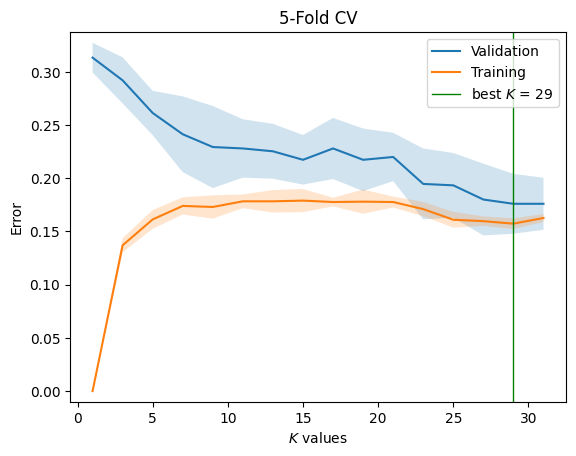

In [11]:
perform_knn_process(ds2, rng=random_seed)

For the second dataset, we can observe the same behavior as the first one in terms of time processing. 

In this case, the selected hyperparameter $k$ is equal to 29.

### Analysis on the Third dataset (d = 500; n = 50000)

Best K: 41

=== TRAINING STAT ===
Accuracy (error): 32.323%
Execution Time: 340.45977762 seconds

=== TEST STAT ===
Accuracy (error): 38.288%
Execution Time: 104.12934642 seconds


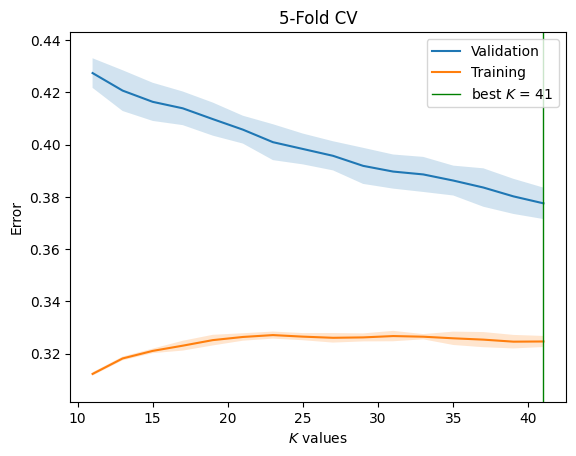

In [12]:
perform_knn_process(ds3, k_values=np.arange(11,42,2), rng=random_seed)

For the third dataset, $K$NN has evaluated $k$ as 31. 

We can see that the execution time is extremely high, but the most relevant result is that the training error is extremely high, so the expected test error is not going to be any lower.
The experimental result confirms the statement above. 

# Logistic Regression

## Methods

In [13]:
# Estimate the gamma parameter: the optimal learning rate for gradient descent
def optimal_gd_learning_rate(Xtr, reg_par):
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    # Calculate L: the Lipschitz constant of the gradient
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

In [14]:
def train_logreg_gd(Xtr, Ytr, reg_par, epsilon = 1e-6, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    epsilon :  the tolerance for the stopping criterion
    maxiter : the maximum number of gradient-descent iterations
    """
    # size of the input in the training
    n, D = np.shape(Xtr)

    # initialization of the vector w
    w = np.zeros((D, 1))

    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)

    # initialization of some supporting variables
    j = 0
    loss_old = 0
    loss = float("inf")
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
       
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss

        # Update the weights and compute the loss
        temp = 0
        loss = 0
        
        for i in np.arange(n):
            temp = temp - Ytr[i]*Xtr[i] / (1+np.exp(Ytr[i] * np.dot(Xtr[i], w)))
            loss = loss + np.log(1 + np.exp(-Ytr[i] * w.T @ Xtr[i]))
            
        temp = temp.reshape(-1, 1)
        w = w - gamma * (temp/n + 2*reg_par*w)

        loss = loss / n + reg_par * (w.T @ w)
        j = j + 1
    
    return w

In [15]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors
    return np.sign(ypred).reshape(-1)

In [16]:
def calcErrorLR(Ypred, Y):
    return np.mean(Ypred != Y)

In [17]:
def KFoldCVLR(Xtr, Ytr, num_folds, lam_list, epsilon=1e-6, maxiter=100, rng: int | Generator | None = None):
    """Run K-Fold CV for the linear regression model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - lam_list : List[int]
         the values of lambda (for LR) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_lam : int
         The value of lam (in lam_list) which obtains the best average validation error
     - best_lam_idx : int
         The index of the best_lam element in lam_list
     - tr_err_mean : np.array
         A 1D array of the same length as lam_list, with the average training error for each tested lam.
     - tr_err_std : np.array
         A 1D array of the same length as lam_list, with the standard deviation 
         of the training error for each tested lam.
     - val_err_mean : np.array
         A 1D array of the same length as lam_list, with the average validation error for each tested lam.
     - val_err_std : np.array
         A 1D array of the same length as lam_list, with the standard deviation
         of the validation error for each tested lam.
    """
    rng = _check_random_generator(rng)
    # Ensures that lam_list is a numpy array
    lam_list = np.array(lam_list)
    num_lam = len(lam_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `lambda` and each fold
    tr_errors = np.zeros((num_lam, num_folds))
    val_errors = np.zeros((num_lam, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for lam_idx, current_lam in enumerate(lam_list):
            # Compute the predicted w with the current lambda
            wpred = train_logreg_gd(x_train, y_train, current_lam, epsilon, maxiter)
            # Compute the training error of the LR classifier for the given value of lambda
            y_tr_pred = predict_logreg(wpred, x_train)
            tr_errors[lam_idx, fold_idx] = calcErrorLR(y_tr_pred, y_train)
            # Compute the validation error of the LR classifier for the given value of lambda
            y_val_pred = predict_logreg(wpred, x_val)
            val_errors[lam_idx, fold_idx] = calcErrorLR(y_val_pred, y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best lambda (lambda which minimize mean validation error) and index of best lambda in lam_list
    best_lam = lam_list[np.argmin(val_err_mean)]
    best_lam_idx = np.where(lam_list == best_lam)
    
    return best_lam, best_lam_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [18]:
def plotErrorsCVLR(reg_pars, best_lam, tr_err_mean, tr_err_std, val_err_mean, val_err_std, num_folds):
    # Plot the training and validation error
    fig, ax = plt.subplots()
    ax.plot(reg_pars, val_err_mean, label="Validation")
    ax.fill_between(reg_pars, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.plot(reg_pars, tr_err_mean, label="Training")
    ax.fill_between(reg_pars, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

    ax.axvline(x=best_lam, color='g', lw=1, label=f"best $\\lambda$ = {best_lam:.3E}")

    ax.set_ylim(bottom=max(min(min(val_err_mean - val_err_std), min(tr_err_mean - tr_err_std))-0.01, -0.01), top=min(max(max(val_err_mean + val_err_std), max(tr_err_mean + tr_err_std))+0.01, 1.01))
    ax.set_title(f"{num_folds}-Fold CV")
    ax.set_ylabel("Error")
    ax.set_xlabel(r"$\lambda$ values")
    ax.set_xscale("log")
    ax.legend(loc="upper right")

In [19]:
def dataLearnLR(dataset, reg_pars = np.logspace(-6, 1, 10), epsilon=1e-6, maxiter=100, num_folds=5, rng: int | Generator | None = None):

    Xtr = dataset['X_train']
    Xte = dataset['X_test']
    Ytr = dataset['y_train']
    Yte = dataset['y_test']

    best_lam, best_lam_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVLR(Xtr, Ytr, num_folds, reg_pars, epsilon, maxiter, rng)

    plotErrorsCVLR(reg_pars, best_lam, tr_err_mean, tr_err_std, val_err_mean, val_err_std, num_folds)
    
    # evaluate the error for training set and test set using the best lambda
    # and estimate the performing time of the linear regression model
    
    time_start = time.perf_counter()
    wpred = train_logreg_gd(Xtr, Ytr, best_lam, epsilon, maxiter)
    time_end = time.perf_counter()

    Ytr_pred = predict_logreg(wpred, Xtr)
    Yte_pred = predict_logreg(wpred, Xte)
    
    tr_error = calcErrorLR(Ytr_pred, Ytr)
    te_error = calcErrorLR(Yte_pred, Yte)


    print(f"Best lambda: {best_lam}\n")
    print("=== TRAINING STAT ===")
    print(f"Error: {tr_error*100:.3f}%")
    print(f"Execution Time: {time_end-time_start:.8f} seconds\n")
    
    print("=== TEST STAT ===")
    print(f"Error: {te_error*100:.3f}%")

## Test on datasets

### Analysis on first dataset (d = 2 ; n = 200)


Best lambda: 1e-06

=== TRAINING STAT ===
Accuracy (error): 10.667%
Execution Time: 0.09300646 seconds

=== TEST STAT ===
Accuracy (error): 12.000%


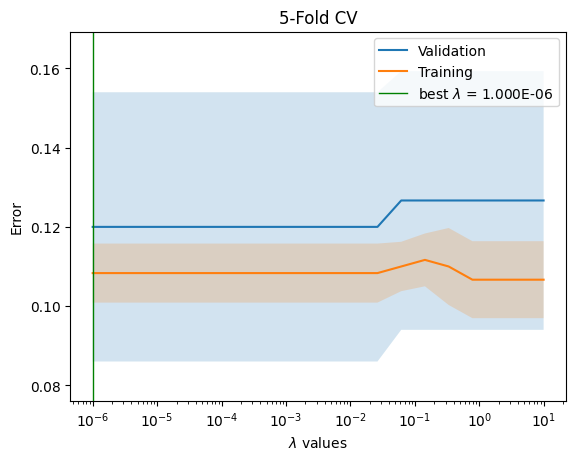

In [20]:
random_seed = 2306

dataLearnLR(ds1, reg_pars = np.logspace(-6, 1, 20), rng=random_seed)

The LR algorithm, contrarily to $K$NN, works globally on the dataset, and not locally. The Gradient Descent algorithm is used to establish the minimum.

Cross-validation looks for the best regularization hyperparameter $\lambda$, which in this case is equal to $10^{-6}$.
The LR training phase allows us to compute the best $w^*$ that will be used to estimate the output for the test set. 
Therefore, we only compute the training time.



### Analysis on the second dataset (d = 10; n = 1000)


Best lambda: 0.14384498882876628

=== TRAINING STAT ===
Accuracy (error): 12.800%
Execution Time: 0.12653096 seconds

=== TEST STAT ===
Accuracy (error): 13.600%


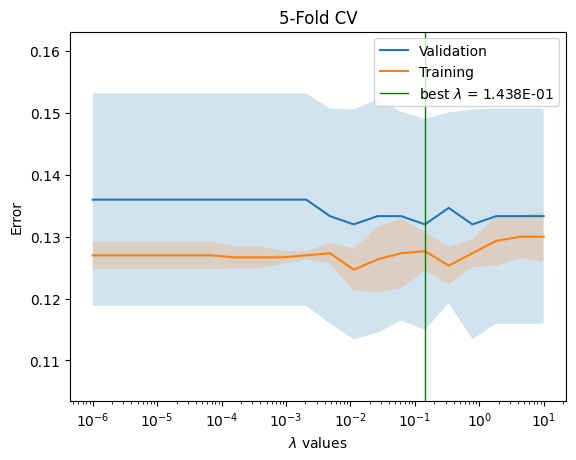

In [21]:
dataLearnLR(ds2, reg_pars = np.logspace(-6, 1, 20), rng=random_seed)

For the second dataset, the hyperparameter $\lambda$ is equal to 0.14384498882876628.


### Analysis on the third dataset (d = 500; n = 50000)

Best lambda: 1e-06

=== TRAINING STAT ===
Accuracy (error): 12.491%
Execution Time: 25.01122579 seconds

=== TEST STAT ===
Accuracy (error): 13.768%


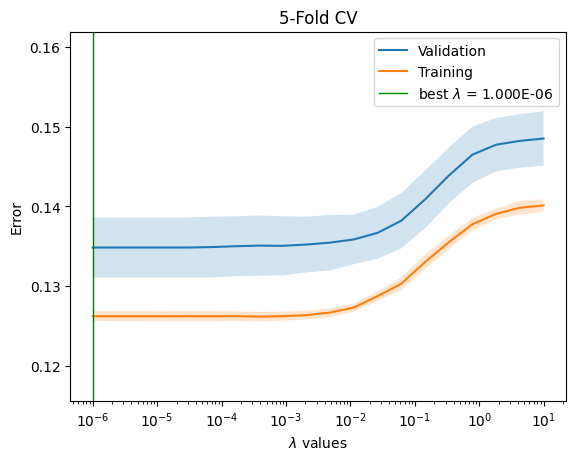

In [23]:
dataLearnLR(ds3, reg_pars = np.logspace(-6, 1, 20), rng=random_seed)

For the third dataset, we can observe that the hyperparameter $\lambda$ is equal to $10^{-6}$.

As the size of the dataset gets bigger, the execution time for the training set gets higher also for LR.


## Comparison between KNN & Logistic Regression

### First dataset

We can observe that on the first dataset the $K$NN algorithm has been faster than the Logistic Regression one by a factor of over 100.

The Accuracy is 12% for both algorithms.

### Second dataset

For the second dataset, Logistic Regression's accuracy is higher than $K$NN's, in fact the error is lower by 4.4%.
In this case too the execution time for the $K$NN algorithm is over 10 times lower than for Logistic Regression.

### Third dataset

On this dataset, we can observe the same behavior as the second one: the accuracy is much better for Logistic Regression, with a difference of 24.52%. 
The computation time is extremely high for $K$NN with a difference between the LR execution time of over 1 minute.


## Final comments

This notebook highlighted key performance differences between $K$-Nearest Neighbors and Logistic regression classifier on three synthetic datasets.
The $K$NN has demonstrated strong performance on smaller, lower-dimensional datasets. However, its computational cost significantly increased with dataset size and dimensionality due to the need to calculate distances to all training points. This issue was evident in the third dataset.
On the other side, the LR classifier has performed robustly across all datasets as it better performed in larger and higher-dimensional scenarios where $K$NN struggled with execution time. Its efficiency stems from optimizing a set of weights rather than direct distance computations for every prediction.

In conclusion, the choice between those classification algorithms depends heavily on the characteristics of the dataset, specifically on its size and dimensionality.
Logistic Regression proved to be a more scalable solution for larger and more complex datasets, while $K$NN remained effective for smaller, simpler problems.
